In [39]:
import sys
import copy
sys.path.insert(0, "..")
from classes.calculators.lennardjones import LennardJones
from classes.atom_classes.atom import Atom
from classes.atom_classes.atom_collection import Atom_Collection
from classes.atom_classes.atom_collection_plotter import Atom_Collection_Plotter, Animator
from classes.descriptors import CoulombMatrixSpectrum
from classes.pca import PCA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA as skPCA
from matplotlib.patches import Ellipse
plt.rc('animation', html='jshtml')

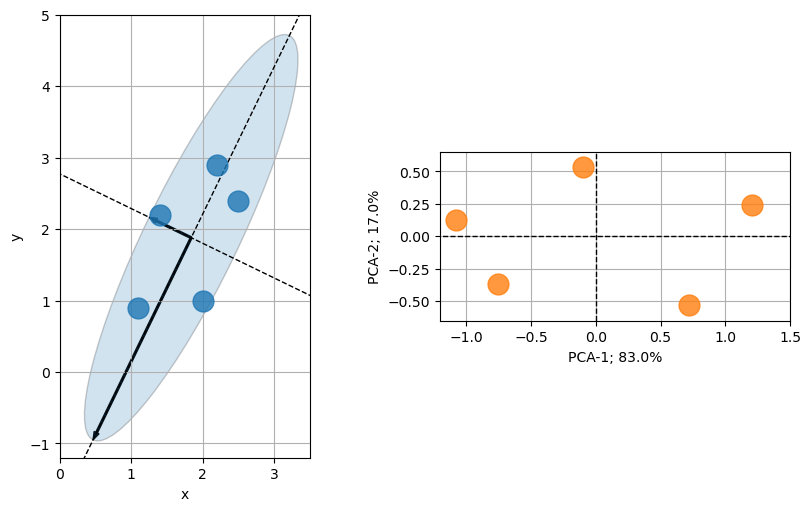

In [168]:
fig, axs = plt.subplots(1,2, figsize=(8,5), layout="constrained")

for ax in axs:
    ax.grid()

axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
axs[1].set_aspect("equal")

data = np.array([[2.5, 2.4],
          [2.0, 1.0],
          [2.2, 2.9],
          [1.4, 2.2],
          [1.1, 0.9]])

pca = PCA(n_components=2)
pca.fit(data=data)
trans_data = pca.transform(data=data)
center = np.mean(data, axis=0)

ts = np.linspace(0.0, 2.0*np.pi, 1000)
ls = []


scale = 3.8

axs[0].set_xlim([0.0, 3.5])
axs[0].set_ylim([-1.2, 5.0])

axs[1].set_xlim([-1.2, 1.5])
axs[1].set_ylim([-0.65, 0.65])

axs[1].vlines(0.0, -3, 3, colors="k", ls="--", lw=1.0)
axs[1].hlines(0.0, -3, 3, colors="k", ls="--", lw=1.0)

for i in range(2):
    v = scale*pca.explained_var[i]*np.array([pca.Q[:,i][0], pca.Q[:,i][1]])
    ts = np.linspace(-4, 4, 100)
    ps = v*ts[:,None] + center
    axs[0].plot(ps[:,0], ps[:,1], c="k", ls="--", lw=1.0)
    l = np.linalg.norm(v)
    ls.append(l)
    axs[0].plot()
    axs[0].arrow(center[0], center[1], v[0], v[1], width=0.025, color="k", length_includes_head=True)


angle = np.pi/2-abs(np.arctan(pca.Q[:,0][0]/pca.Q[:,0][1]))

ellipse = Ellipse(center, width=2*ls[0], height=2*ls[1], angle=angle*180/np.pi, alpha=0.2, edgecolor="k")

axs[0].add_patch(ellipse)


axs[1].set_xlabel(f"PCA-1; {round(pca.explained_var[0], 2)*100}%")
axs[1].set_ylabel(f"PCA-2; {round(pca.explained_var[1], 2)*100}%")

axs[0].plot(data[:,0], data[:,1], 'o', markersize=15, alpha=0.8)
axs[1].plot(trans_data[:,0], trans_data[:,1], 'o', markersize=15, alpha=0.8, c="C1")
axs[0].set_aspect("equal")

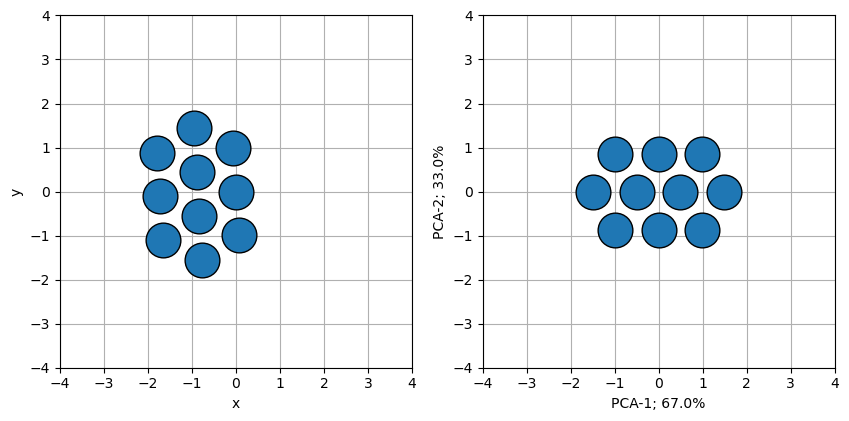

In [174]:
pos_flat = np.loadtxt('lj10clusters.txt')
positions = pos_flat.reshape(-1,pos_flat.shape[1]//2,2)
atom_cols = [Atom_Collection([Atom(position=pos) for pos in poses]) for poses in positions]
data = atom_cols[17].get_positions()
pca = PCA(2)
pca.fit(data=data)

atom_plotter = Atom_Collection_Plotter(markersize=25)

trans_data = pca.transform(data=data)
atom_col_rotated = Atom_Collection(atomlist=[Atom(position=pos) for pos in trans_data])

fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")

axs[1].set_xlabel(f"PCA-1; {round(pca.explained_var[0], 2)*100}%")
axs[1].set_ylabel(f"PCA-2; {round(pca.explained_var[1], 2)*100}%")

for ax, atom_col in zip(axs, [atom_cols[17], atom_col_rotated]):
    ax.grid()
    ax.set_xlim([-4,4])
    ax.set_ylim([-4,4])
    ax.set_aspect("equal")
    atom_plotter(atom_col=atom_col, ax=ax)
    atom_col.reset_plot_axes()

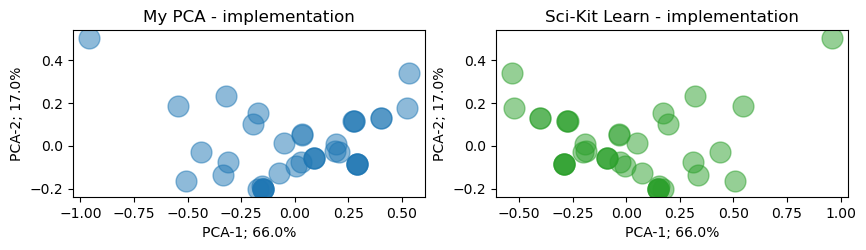

In [183]:
coul_desc = CoulombMatrixSpectrum()
descriptors = [coul_desc.get_descriptor(atom_col=atom_col) for atom_col in atom_cols]
my_pca = PCA(2)
skpca = skPCA(2)
pcas = [my_pca, skpca]

for pca in pcas:
    pca.fit(descriptors)

fig, axs = plt.subplots(1,2, figsize=(10,5))

axs[0].set_title("My PCA - implementation")
axs[1].set_title("Sci-Kit Learn - implementation")



for pca, ax, color, exp_vars in zip(pcas, axs, ["C0","C2"], [my_pca.explained_var, skpca.explained_variance_ratio_]):
    ax.set_xlabel(f"PCA-1; {round(exp_vars[0], 2)*100}%")
    ax.set_ylabel(f"PCA-2; {round(exp_vars[1], 2)*100}%")
    ax.set_aspect("equal")
    trans_data = pca.transform(descriptors)
    ax.plot(trans_data[:,0], trans_data[:,1], 'o', markersize=15, alpha=0.5, color=color)

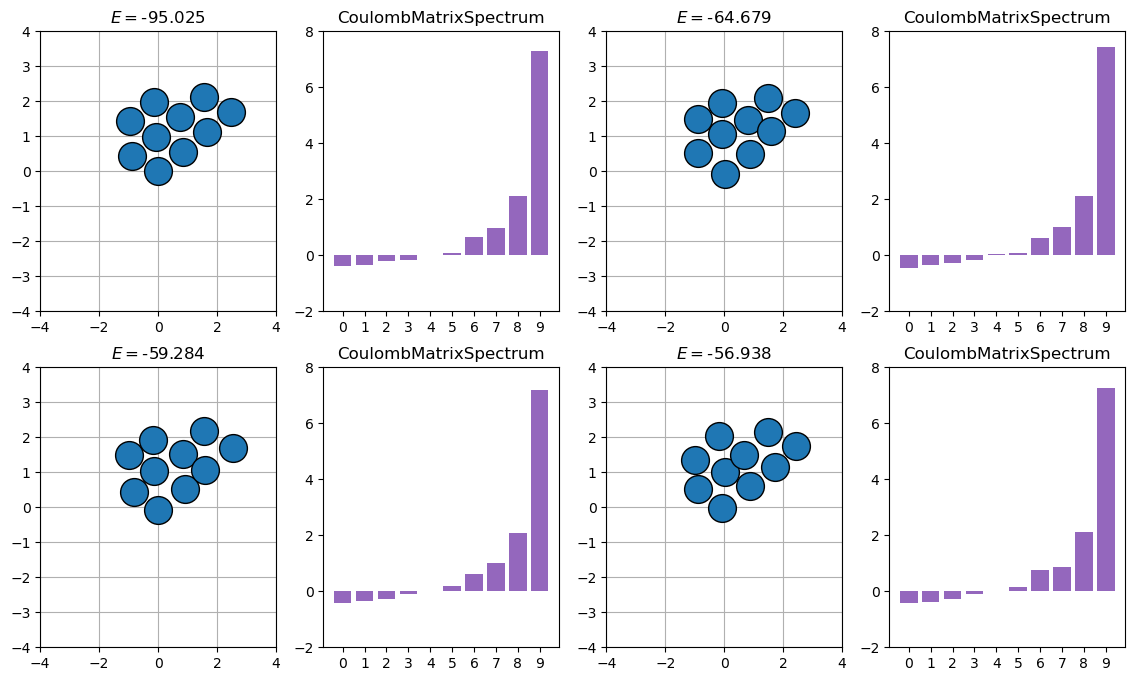

In [188]:
fig, axs = plt.subplots(2,4, figsize=(14,8))
atom_cols_for_rattling = [copy.deepcopy(atom_cols[2])  for i in range(4)]
atom_plotter = Atom_Collection_Plotter(markersize=20)
for i, ax in enumerate(axs.reshape(4,2)):
    ax[0].set_xlim([-4,4])
    ax[0].set_ylim([-4,4])
    ax[0].grid()
    atom_cols_for_rattling[i].calculator = LennardJones()
    if i > 0:
        atom_cols_for_rattling[i].rattle_atoms(delta=0.08)
        atom_plotter(atom_cols_for_rattling[i], ax=ax[0])
        coul_desc.plot(atom_col=atom_cols_for_rattling[i], ax=ax[1])
        ax[0].set_title(rf"$E=${atom_cols_for_rattling[i].get_potential_energy().round(3)}")
    else:
        atom_plotter(atom_cols_for_rattling[i], ax=ax[0])
        ax[0].set_title(rf"$E=${atom_cols_for_rattling[i].get_potential_energy().round(3)}")
        coul_desc.plot(atom_col=atom_cols_for_rattling[i], ax=ax[1])

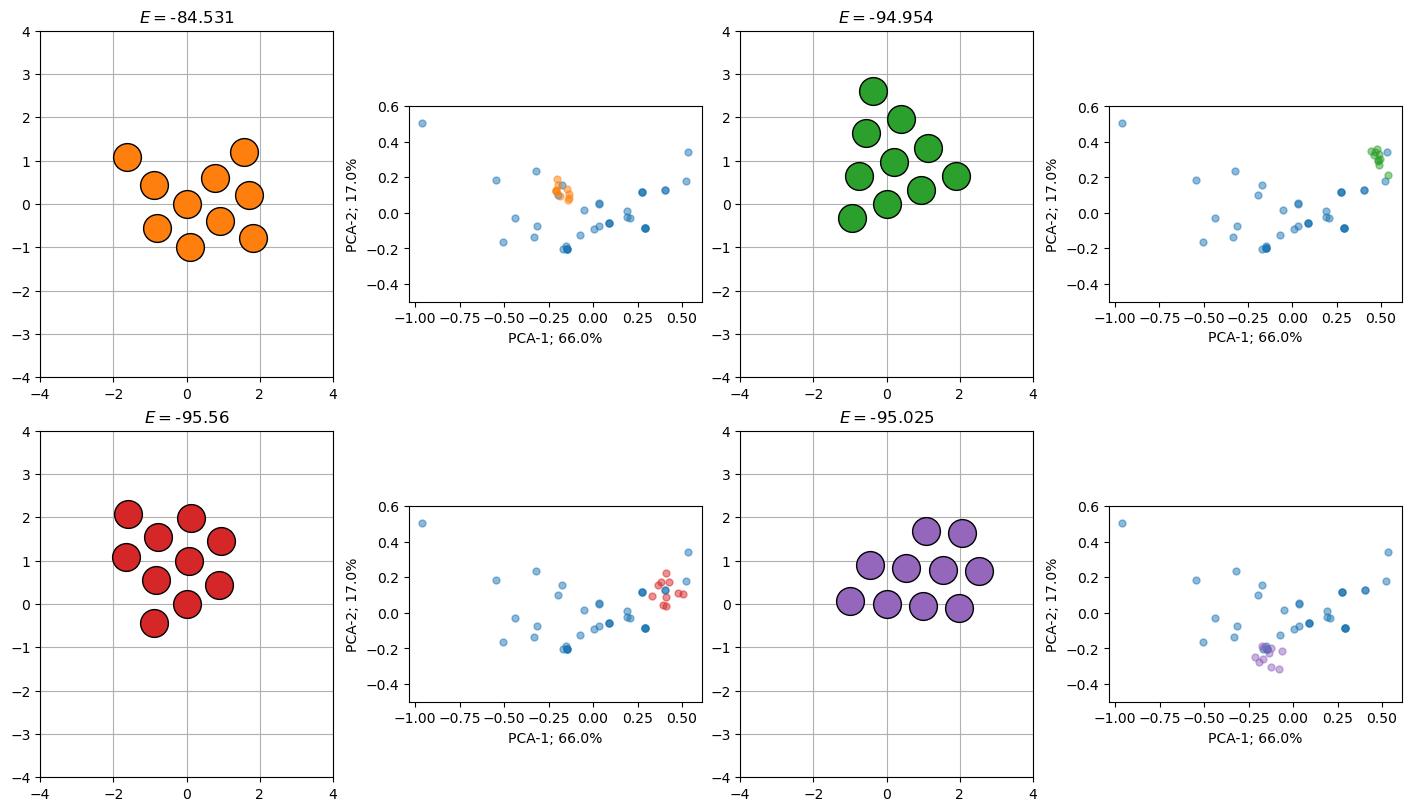

In [199]:
atom_cols_for_rattling = [copy.deepcopy(atom_cols[i+4])  for i in range(4)]
fig, axs = plt.subplots(2,4, figsize=(14,8), layout="constrained")

pca = PCA(2)
pca.fit(data=descriptors)
trans_data = pca.transform(data=descriptors)
colors = ["C1", "C2", "C3", "C4"]
for ax, atom_col, color in zip(axs.reshape(4,2), atom_cols_for_rattling, colors):
    ax[0].grid()
    atom_plotter = Atom_Collection_Plotter(default_cols=(color, "C1"), markersize=20)
    ax[0].set_xlim([-4,4])
    ax[0].set_ylim([-4,4])
    atom_col.calculator = LennardJones()
    ax[0].set_title(rf"$E=${atom_col.get_potential_energy().round(3)}")
    atom_plotter(atom_col=atom_col, ax=ax[0])
    ax[1].set_aspect("equal")
    ax[1].plot(trans_data[:,0], trans_data[:,1], 'o', markersize=5, alpha=0.5, color="C0")
    ax[1].set_xlabel(f"PCA-1; {round(exp_vars[0], 2)*100}%")
    ax[1].set_ylabel(f"PCA-2; {round(exp_vars[1], 2)*100}%")
    ax[1].set_ylim([-0.5,0.6])
    rattled_descriptors = []
    for i in range(10):
        atom_col_for_rattle = copy.deepcopy(atom_col)
        atom_col_for_rattle.rattle_atoms(delta=0.04)
        desc = coul_desc.get_descriptor(atom_col=atom_col_for_rattle)
        rattled_descriptors.append(desc)
    new_data = pca.transform(data=rattled_descriptors)
    ax[1].plot(new_data[:,0], new_data[:,1], 'o', markersize=5, alpha=0.5, color=color)